# Aula 3.1(2): Classificação: Dataset Titanic
Objetivo: Prever se um passageiro sobreviveu ao naufrágio do Titanic (classificação binária)

Passos:
1. Carregamento e Exploração dos Dados.
2. Pré-processamento: tratar valores ausentes (missing values); codificar variáveis categóricas; criar novas features (feature engineering).
3. Treinamento de Modelos: modelo base: Regressão Logística; modelos avançados: Random Forest e Gradient Boosting.
4. Ajuste de Hiperparâmetros: usar GridSearchCV para otimizar o Random Forest.
5. Ensemble Learning: combinar previsões com VotingClassifier.
6. Avaliação e Visualização: matriz de confusão e métricas detalhadas.

## Roteiro de execução

1. Carregamento e Exploração dos Dados

   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-nu

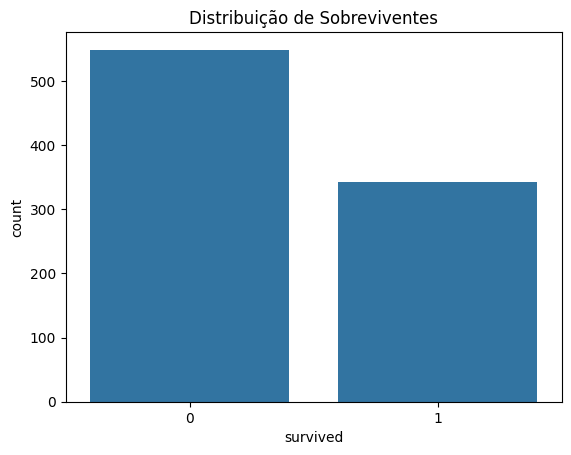

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Carregar o dataset Titanic do seaborn
# https://github.com/mwaskom/seaborn-data/blob/master/titanic.csv
df = sns.load_dataset('titanic')

# Visualizar as primeiras linhas
print(df.head())

# Resumo básico
print(df.info())

# Visualizar distribuição da variável alvo
sns.countplot(x='survived', data=df)
plt.title('Distribuição de Sobreviventes')
plt.show()

2. Pré-processamento
- Tratar valores ausentes (missing values).
- Codificar variáveis categóricas.
- Criar novas features (feature engineering).

In [2]:
# Tratar valores ausentes
df['age'] = df['age'].fillna(df['age'].median())
df['embarked'] = df['embarked'].fillna(df['embarked'].mode()[0])

# Codificar variáveis categóricas
df = pd.get_dummies(df, columns=['sex', 'embarked','who'], drop_first=True)

# Garantindo que a variável 'alone' esteja no formato correto(1|0) para os modelos
df['alone'] = df['alone'].astype(int)

# Feature engineering: criar variável 'family_size'
df['family_size'] = df['sibsp'] + df['parch'] + 1

# Selecionar features e alvo
X = df[['pclass', 'age', 'fare', 'family_size', 'sex_male', 'embarked_Q', 'embarked_S','alone','who_man', 'who_woman']]
y = df['survived']

3. Treinamento de Modelos
- Modelo base: Regressão Logística.
- Modelos avançados: Random Forest e Gradient Boosting.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Dividir os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo base: Regressão Logística
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
print("Acurácia Regressão Logística:", accuracy_score(y_test, y_pred_log))

# Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Acurácia Random Forest:", accuracy_score(y_test, y_pred_rf))

# Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
print("Acurácia Gradient Boosting:", accuracy_score(y_test, y_pred_gb))

Acurácia Regressão Logística: 0.8100558659217877
Acurácia Random Forest: 0.8156424581005587
Acurácia Gradient Boosting: 0.8268156424581006


4. Ajuste de Hiperparâmetros
- Usar GridSearchCV para otimizar o Random Forest.

In [4]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor acurácia:", grid_search.best_score_)

Melhores parâmetros: {'max_depth': 10, 'n_estimators': 200}
Melhor acurácia: 0.8216389244558258


5. Ensemble Learning
- Combinar previsões com VotingClassifier.

In [10]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('gb', gb), ('lr', log_reg)],
    voting='hard'
)
voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)
print("Acurácia Voting Classifier:", accuracy_score(y_test, y_pred_voting))

Acurácia Voting Classifier: 0.8324022346368715


6. Avaliação e Visualização
- Matriz de confusão e métricas detalhadas.

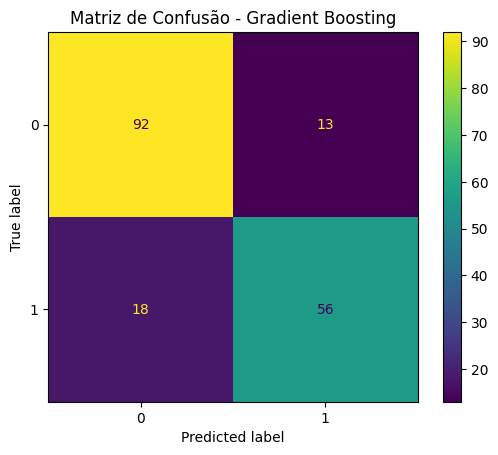

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       105
           1       0.81      0.76      0.78        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_gb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Matriz de Confusão - Gradient Boosting')
plt.show()

print(classification_report(y_test, y_pred_gb))

## Exercício

Tente melhorar o modelo Gradient Boosting adicionando uma nova feature (ex.: extrair título do nome dos passageiros). Comente suas ações e quais resultados obteve.

Adicionando três novas features (alone, who_man e who_woman) para ajudar os modelos a identificar melhor se as características do passageiro(a),no caso ser homem ou mulher e viajar sozinho ou não. Se elas ajudavam no seu desempenho para classificar de forma correta a variável alvo (survived).Com isso, vemos que todos os modelos foram afetados, o que já era esperado. Dois foram beneficiados, aumentando sua acurácia, como a Regressão Logística e o Gradient Boosting, enquanto o Random Forest foi prejudicado, reduzindo sua acurácia, O Gradient Boosting, em especial, apresentou uma melhoria, pois com essas novas features conseguiu classificar corretamente mais sobreviventes. Antes, classificava corretamente 51 pessoas que realmente sobreviveram, agora, classifica 56. No entanto, cometeu um pequeno erro a mais na classificação dos não sobreviventes, no caso antes, classificava corretamente 93 pessoas que não sobreviveram, agora, classifica 92, sua acurácia geral aumentou de 80% para 83%.
